## Software Life Cycle 

In [1]:
import os
from dotenv import load_dotenv

# Load env vars
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq

# Initialize Llama model
llm = ChatGroq(model="llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x750f44f88460>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x750f44f89810>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
from typing import List
from pydantic import BaseModel, Field


class UserStory(BaseModel):
    title: str = Field(
        description="Title of the user story summarizing the functionality."
    )
    description: str = Field(
        description="Detailed user story following the format: 'As a [user], I want to [action] so that [benefit]'."
    )
    acceptance_criteria: List[str] = Field(
        description="List of acceptance criteria that define when this story is complete."
    )


class UserStories(BaseModel):
    stories: List[UserStory] = Field(
        default_factory=list, description="List of generated user stories."
    )
    
user_story_evaluator = llm.with_structured_output(UserStories)

In [5]:
from typing_extensions import TypedDict
from src.state.user_stories import UserStories


class LifeCycleState(TypedDict):
    prompt: str
    user_stories: UserStories

In [7]:
# Nodes
def get_user_requirement(state: LifeCycleState):
    """Generates structured user stories from user requirements using the `UserStories` schema."""
    result = user_story_evaluator.invoke(
        f"Split the following requirements into distinct user stories. "
        f"Each user story should include a title, description, and acceptance criteria: {state['prompt']}"
    )
    return {"user_stories": result}

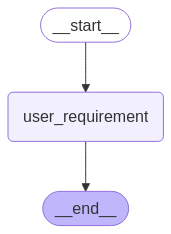

In [9]:
from langgraph.graph import StateGraph, START, END

# Build Workflow
workflow_builder = StateGraph(LifeCycleState)

# Add nodes
workflow_builder.add_node("user_requirement", get_user_requirement)

# Add edges to connect nodes
workflow_builder.add_edge(START, "user_requirement")
workflow_builder.add_edge("user_requirement", END)

# Compile
workflow = workflow_builder.compile()
workflow